![imagen.png](./fig/FM_espectro.png)

In [1]:
from rtlsdr import RtlSdr  
import numpy as np  
import scipy.signal as signal
from scipy.signal import butter, lfilter, freqz
import matplotlib  
#matplotlib.use('Agg') # necessary for headless mode  
# see http://stackoverflow.com/a/3054314/3524528
from pylab import *
import matplotlib.pyplot as plt
%matplotlib inline


In [2]:
# Funcion para graficar el espectro en funcion del timepo
def plotSG(x,Fs):
    plt.specgram(x, NFFT=2048, Fs=Fs)  
    plt.xlabel("Time (s)")  
    plt.ylabel("Frequency (Hz)") 
    plt.ylim(-Fs/2, Fs/2)  
    #plt.plot("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
    plt.xlim(0,len(x)/Fs)  
    plt.ticklabel_format(style='plain', axis='y' )  
    plt.show()
    plt.close()
    
    
def plotSGS(x,Fs):
    plt.specgram(x, NFFT=2048, Fs=Fs)  
    plt.xlabel("Time (s)")  
    plt.ylabel("Frequency (Hz)") 
    plt.ylim(0, Fs/2)  
    #plt.plot("x1_spec.pdf", bbox_inches='tight', pad_inches=0.5)  
    plt.xlim(0,len(x)/Fs)  
    plt.ticklabel_format(style='plain', axis='y' )  
    plt.show()
    plt.close()    
    
def plot_response(fs, w, h, title):
    "Utility function to plot response functions"
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(0.5*fs*w/np.pi, 20*np.log10(np.abs(h)))
    ax.set_ylim(-40, 5)
    ax.set_xlim(0, 0.5*fs)
    ax.grid(True)
    ax.set_xlabel('Frequency (Hz)')
    ax.set_ylabel('Gain (dB)')
    ax.set_title(title) 
    
    
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = lfilter(b, a, data)
    return y



In [3]:
F_station = int(99.9e6)  # Pick a radio station

# We capture at an offset to avoid DC spike
F_offset = 250e3         # Offset to capture at  
Fc = F_station - F_offset # Capture center frequency 

Fs = int(1.140e6)         # Sample rate  
N = int(8.192e6)          # Samples to capture

print('Freq samples = {:1.3f} Msps'.format(Fs/1e6))

print('Windows time = {:1.2f} s'.format(N/Fs))
print('sample  step = {:1.2e} us'.format(1e6/Fs))

print('Min Freq     = {:1.2f} Hz'.format(Fs/N))
print('Max Freq     = {:1.2f} KHz'.format(Fs/2/1e3))

Freq samples = 1.140 Msps
Windows time = 7.19 s
sample  step = 8.77e-01 us
Min Freq     = 0.14 Hz
Max Freq     = 570.00 KHz


In [4]:
# Open RTL 
sdr = RtlSdr()

# configure device
sdr.sample_rate = Fs      # Hz  
sdr.center_freq = Fc      # Hz  
sdr.gain = 'auto'

# Read samples
samples = sdr.read_samples(N)

# Clean up the SDR device
sdr.close()  
del(sdr)



In [5]:
#import pickle
  
# Open a file and use dump()
#with open('file.pkl', 'wb') as file:
    # A new file will be created
    #pickle.dump(samples, file)

In [6]:
#import pickle
  
# Open the file in binary mode
#with open('file.pkl', 'rb') as file:
      
    # Call load method to deserialze
    #myvar = pickle.load(file)

<class 'numpy.complex128'>
(-0.03529412+0.05882353j)


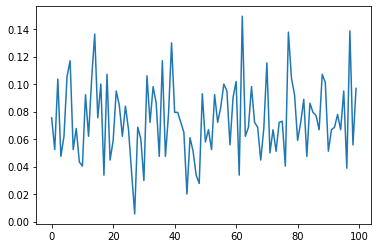

In [7]:
# Convert samples to a numpy array
x1 = np.array(myvar).astype("complex64")

print(type(samples[100]))
print((x1[100]))


plt.plot(abs(x1[:100]))
plt.show()

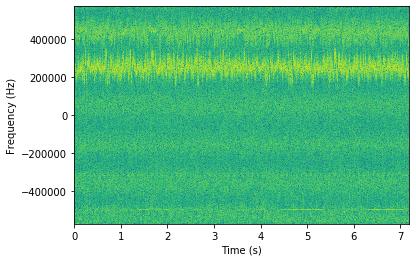

In [8]:
plotSG(x1,Fs)


In [9]:
# To mix the data down, generate a digital complex exponential 
# (with the same length as x1) with phase -F_offset/Fs

fc1 = np.exp(-1.0j*2.0*np.pi* F_offset*np.arange(len(x1))/Fs)  

print(fc1[0:10])

[ 1.        +0.j          0.19171063-0.98145149j -0.92649407-0.37630937j
 -0.54694816+0.83716648j  0.71678251+0.6972968j   0.82177782-0.56980806j
 -0.40169542-0.91577333j -0.97579638+0.21868109j  0.02755434+0.99962031j
  0.9863613 +0.16459459j]


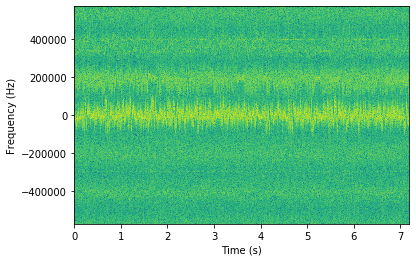

In [10]:
# Now, just multiply x1 and the digital complex expontential
x2 = x1 * fc1  


plotSG(x2,Fs)

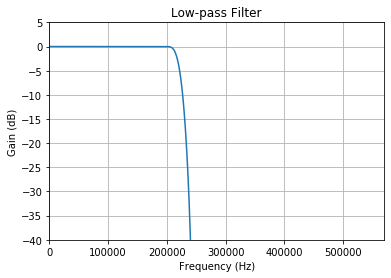

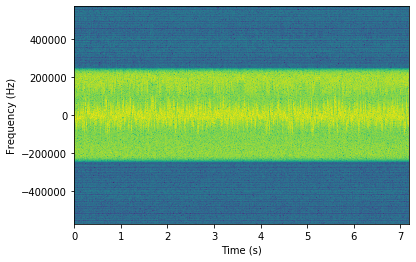

(-0.012792225268272924-0.0038327004828701515j)


In [11]:
# An FM broadcast signal has a bandwidth of 200 kHz
f_bw = 200000 
cutoff      = f_bw                # Desired cutoff frequency, Hz
trans_width = (Fs/2-f_bw)/8  # Width of transition from pass band to stop band, Hz
n_taps      = 128  # Size of the FIR filter.

# Use Remez algorithm to design filter coefficients
lpf = signal.remez(n_taps, [0, cutoff, cutoff + trans_width, Fs/2], [1,0], Hz=Fs)  

w, h = signal.freqz(lpf, [1], worN=2000)
plot_response(Fs, w, h, "Low-pass Filter")
plt.show()



# Filtro pasabajos para eliminar canales adyacentes 
x3  = signal.lfilter(lpf, 1.0, x2)

plotSG(x3,Fs)
print((x3[100]))

5
New Freq samples = 228000 sps


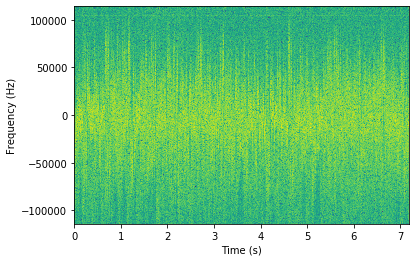

[0.01335405 0.05916585 0.08077558 0.08460228 0.07796145 0.05834363
 0.0317267  0.03607638 0.0523457  0.04037671]
[0.01335405 0.05834363]
1638400


In [12]:
dec_rate = int(Fs / f_bw)  
print(dec_rate)
x4 = x3[0::dec_rate]  
# Calculate the new sampling rate
Fs_y = Fs/dec_rate

print('New Freq samples = {:1.0f} sps'.format(Fs_y))

plotSG(x4,Fs_y)

print(abs(x3[100:110]))
print(abs(x4[int(100/dec_rate):int(100/dec_rate)+2]))
print(len(x4))

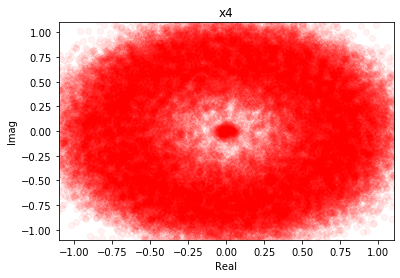

In [13]:
# Plot the constellation of x4.  What does it look like?
plt.scatter(np.real(x4[0:50000]), np.imag(x4[0:50000]), color="red", alpha=0.05)  
plt.title("x4")  
plt.xlabel("Real")  
plt.xlim(-1.1,1.1)  
plt.ylabel("Imag")  
plt.ylim(-1.1,1.1)  
#plt.plot("x4_const.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  


$$x_4 = [a e^{j \cdot \theta_a} , b e^{j \cdot \theta_b}, ...  ]$$

$$y_5 = [b e^{j \cdot \theta_b} \cdot a e^{j \cdot \theta_a} ,...]$$

$$y_5 = [b \cdot a e^{j \cdot (\theta_b -\theta_a)} ,...]$$

$$x_5 = ang(y_5) = \theta_b -\theta_a$$



-1.4419132493810254


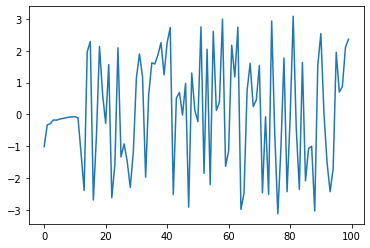

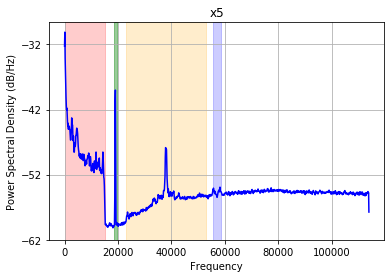

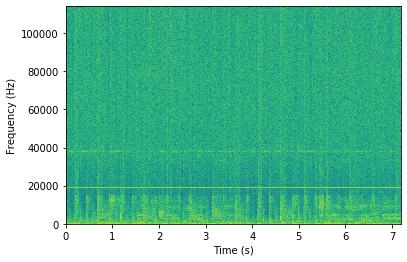

In [14]:
### Polar discriminator
y5 = x4[1:] * np.conj(x4[:-1])  
x5 = np.angle(y5)  


print(x5[100])
plt.plot(x5[:100])
plt.show()

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x5, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("x5")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

plotSGS(x5,Fs_y)

# Pre-emphasis

As we already know that in FM, the noise has a greater effect on the higher modulating frequencies. 
This effect can be reduced by increasing the value of modulation index (mf ) for higher modulating frequencies (fm).

This can be done by increasing the deviation Δf and Δf can be increased by increasing the amplitude of modulating signal at higher modulating frequencies.

Thus, if we boost the amplitude of higher frequency modulating signals artificially then it will be possible to improve the noise immunity at higher modulating frequencies.

The artificial boosting of higher modulating frequencies is called as pre-emphasis.

Boosting of higher frequency modulating signal is achieved by using the pre-emphasis circuit as shown in fig.1(a).

![](./fig/FM_pre.png)

As shown in the fig.1, the modulating AF signal is passed through a high pass RC filter, before applying it to the FM modulator.

As fm increases, reactance of C decreases and modulating voltage applied to FM modulator goes on increasing.

The frequency response characteristics of the RC high pass network is shown in fig.1(b).

The boosting is done according to this pre arranged curve.

The amount of pre-emphasis in US FM transmission and sound transmission in TV has been standardized at 75 μsec.

The pre-emphasis circuit is basically a high pass filter. The pre-emphasis is carried out at the transmitter.The frequency for the RC high pass network is 2122 Hz as shown in fig.1 (b). Hence, the pre-emphasis circuit is used at the transmitter as shown in fig.2.

![](./fig/FM_pre_2.png)

# De-emphasis

The process that is used at the receiver end to nullify or compensate the artificial boosting given to the higher modulating frequencies in the process of pre-emphasis is called De-emphasis.

That means, the artificially boosted high frequency signals are brought to their original amplitude using the de-emphasis circuit.

The 75 μsec de-emphasis circuit is standard and it is as shown in fig. 3.

![](./fig/FM_de_1.png)

Tt shows that it is a low pass filter. 75 μsec de-emphasis corresponds to a frequency response curve that is 3 dB down at a frequency whose RC time constant is 75 μsec.i.e.,

The demodulated FM is applied to the De-emphasis circuit. With increase in fm the reactance of C goes on decreasing and the output of de-emphasis circuit will also reduce as shown in fig.3.

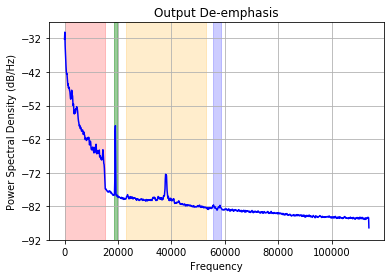

In [15]:
# The de-emphasis filter
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.lfilter.html
# Given a signal 'x5' (in a numpy array) with sampling rate Fs_y
d = Fs_y * 75e-6   # Calculate the # of samples to hit the -3dB point  
x = np.exp(-1/d)   # Calculate the decay between each sample  
b = [1-x]          # Create the filter coefficients  
a = [1,-x]  
x6 = signal.lfilter(b,a,x5)  

# Note: x5 is now an array of real, not complex, values
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x6, NFFT=2048, Fs=Fs_y, color="blue")  
plt.title("Output De-emphasis")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
plt.axvspan(19000*2-15000, 19000*2+15000, color="orange", alpha=0.2)  
plt.axvspan(19000*3-1500,  19000*3+1500,  color="blue", alpha=0.2)  
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()
plt.close()  

45600.0


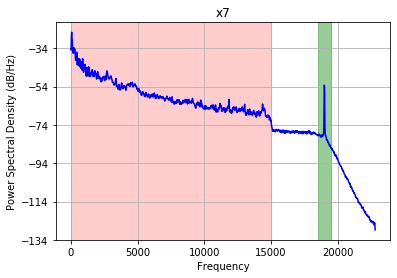

In [16]:
# Find a decimation rate to achieve audio sampling rate between 44-48 kHz
audio_freq  = 44100.0
dec_audio   = int(Fs_y/audio_freq) 
Fs_audio   = Fs_y / dec_audio
print(Fs_audio)
x7 = signal.decimate(x6, dec_audio)  


# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(x7, NFFT=2048, Fs=Fs_audio, color="blue")  
plt.title("x7")  
plt.axvspan(0,             15000,         color="red", alpha=0.2)  
plt.axvspan(19000-500,     19000+500,     color="green", alpha=0.4)  
 
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

plt.close()  

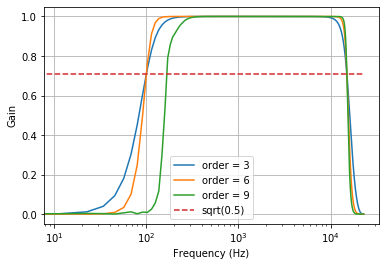

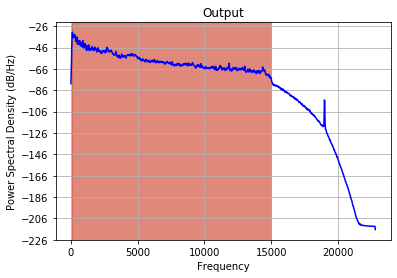

In [17]:
highcut = 15e3  # Cut-off frequency of the filter
lowcut = 100
fs = Fs_audio
# w = fc / (Fs_audio / 2) # Normalize the frequency
# b, a = signal.butter(10, w, 'low')
# output = signal.filtfilt(b, a, x7)


# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [3, 6, 9]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.semilogx([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.show()



output = butter_bandpass_filter(x7, lowcut, highcut, Fs_audio, order=6)
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(output, NFFT=2048, Fs=Fs_audio, color="blue")  
plt.title("Output")  
plt.axvspan(lowcut,        highcut,     color="green", alpha=0.2)  
plt.axvspan(lowcut-10,     highcut+10,     color="red", alpha=0.4)  

 
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

plt.close()  

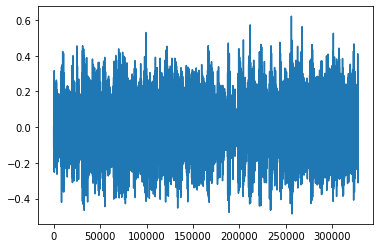

In [18]:
# Scale audio to adjust volume
output *= 0.5 / np.max(np.abs(x7))  
# Save to file as 16-bit signed single-channel audio samples
#output.astype("int16").tofile("wbfm-mono.raw")  

plt.plot(output)

In [19]:
from scipy.io import wavfile

sampleRate = 45600


wavfile.write('output.wav', sampleRate, output)

In [ ]:
## Pilot!

highcut = 19.3e3  # Cut-off frequency of the filter
lowcut  = 18.7e3  
fs      = Fs_y
# w = fc / (Fs_audio / 2) # Normalize the frequency
# b, a = signal.butter(10, w, 'low')
# output = signal.filtfilt(b, a, x7)


# Plot the frequency response for a few different orders.
plt.figure(1)
plt.clf()
for order in [2, 3, 4]:
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    w, h = freqz(b, a, worN=2000)
    plt.plot((fs * 0.5 / np.pi) * w, abs(h), label="order = %d" % order)

plt.semilogx([0, 0.5 * fs], [np.sqrt(0.5), np.sqrt(0.5)],
         '--', label='sqrt(0.5)')
plt.xlim([lowcut*0.9,highcut*1.1])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Gain')
plt.grid(True)
plt.legend(loc='best')
plt.show()



output = butter_bandpass_filter(x5, lowcut, highcut, fs, order=3)
# As a result, the PSDs will now be plotted single-sided by default (since
# a real signal has a symmetric spectrum)
# Plot the PSD of x5
plt.psd(output, NFFT=2048, Fs=fs, color="blue")  
plt.title("Output")  
plt.axvspan(lowcut,        highcut,     color="green", alpha=0.2)  
plt.axvspan(lowcut-10,     highcut+10,     color="red", alpha=0.4)  
plt.ylim([-100,-30]) 
plt.xlim([lowcut,highcut]) 
plt.ticklabel_format(style='plain', axis='y' )  
#plt.plot("x5_psd.pdf", bbox_inches='tight', pad_inches=0.5)  
plt.show()

plt.close()  

In [ ]:
plt.plot(output)